# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Check the population data set - sample of 10
azdias.head(n=10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
# Check the population data set - shape
azdias.shape

(891221, 85)

In [5]:
# Check the population data set - quick stats
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [6]:
# Check the feature information data set - sample of 10
feat_info.head(n=10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
# Check the feature information data set - shape
feat_info.shape

(85, 4)

In [8]:
# Check the feature information data set - quick stats
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_ERL,person,ordinal,[-1]
freq,1,43,49,26


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
#  Identify missing or unknown data values and convert them to NaNs.

In [10]:
# S1) Quantify the initial missing data for each column
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

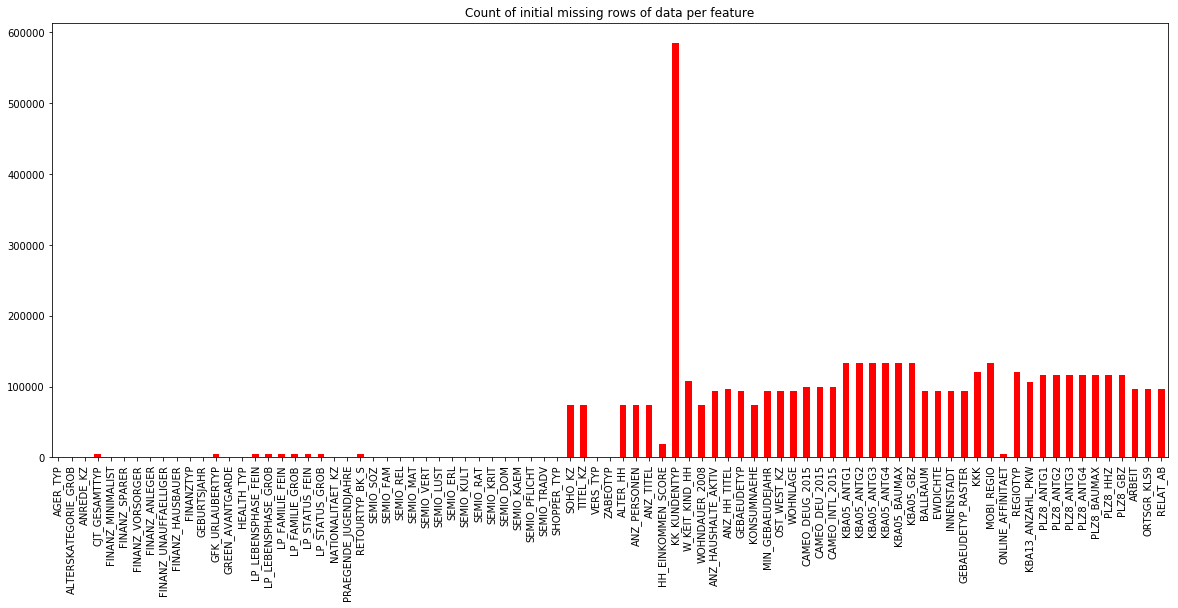

In [11]:
# S2) Visualise the missing data - initial
azdias.isnull().sum().plot.bar(figsize=(20,8), color = 'red', 
                               title='Count of initial missing rows of data per feature');

In [12]:
# S3) Quantify the total number of rows with missing data - initial

print('Total instances of missing data for all features - initial: {}'
      .format(azdias.isnull().sum().sum()))

Total instances of missing data for all features - initial: 4896838


In [13]:
# S4) Create function to convert missing/unknown values into NaN
def convert_missing_unknown_to_nan(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [14]:
# S5) Convert the missing and unknown values into NaN

# Create a copy
azdias_processed_01 = azdias
# Perform conversion
azdias_processed_01 = convert_missing_unknown_to_nan(azdias_processed_01)

In [15]:
# S6) Quantify the initial missing data for each column
azdias_processed_01.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

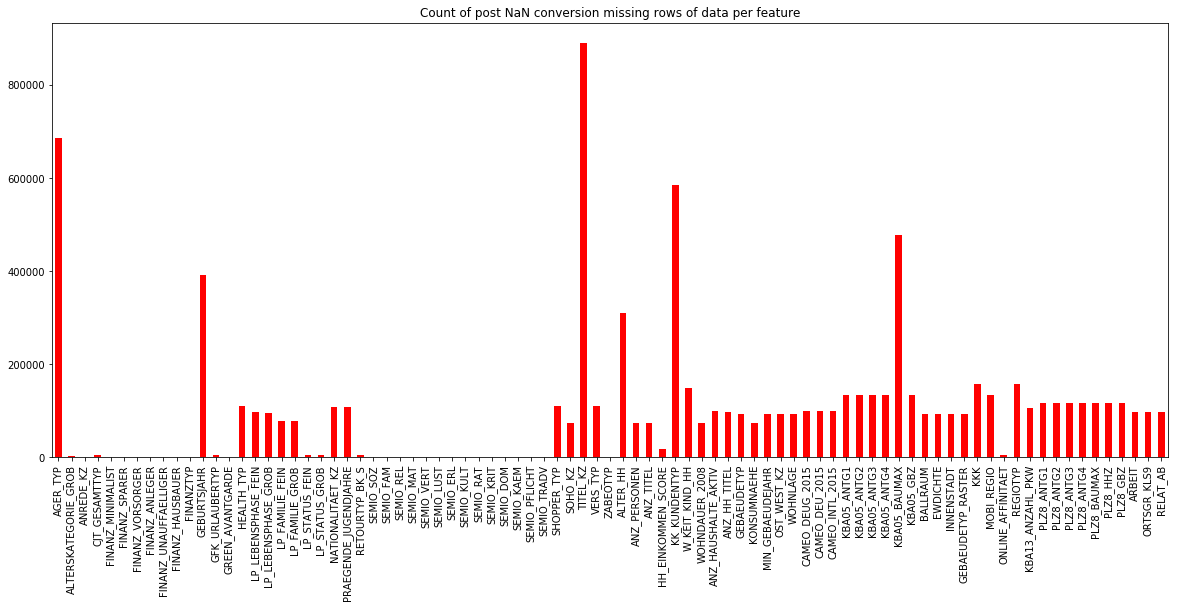

In [16]:
# S7) Visualise the missing data - initial
azdias_processed_01.isnull().sum().plot.bar(figsize=(20,8), color = 'red',
                                            title='Count of post NaN conversion missing rows of data per feature');

In [17]:
# S8) Quantify the total number of rows with missing data - processed (post NaN conversion)

print('Total instances of missing data for all features - processed (post NaN conversion): {}'
      .format(azdias_processed_01.isnull().sum().sum()))

Total instances of missing data for all features - processed (post NaN conversion): 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

In [19]:
# Calculate for each column, the percentage of data that is missing
pct_missing_per_column = (azdias_processed_01.isnull().sum()/len(azdias_processed_01))*100

In [20]:
# Quick view of columns with missing data, regardless of percentage
pct_missing_per_column[pct_missing_per_column>0]

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SHOPPER_TYP              12.476816
SOHO_KZ                   8.247000
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
HH_EINKOMMEN_SCORE        2.058749
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
WOHNDAUER_2008            8.247000
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP         

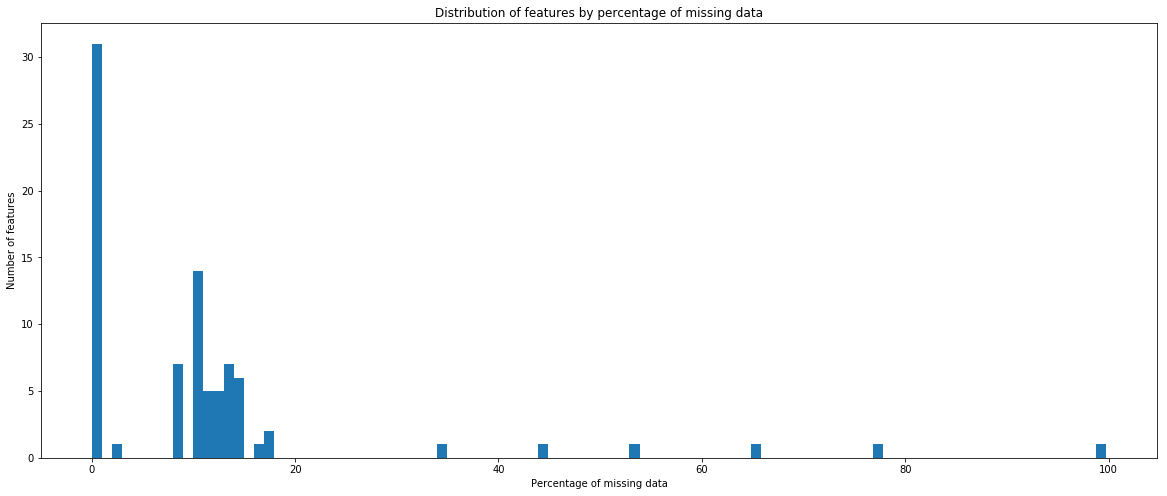

In [102]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(pct_missing_per_column, bins=100)

plt.title('Distribution of features by percentage of missing data')
plt.xlabel('Percentage of missing data')
plt.ylabel('Number of features')
plt.rcParams["figure.figsize"] = [20,8]
plt.show()

In [22]:
# Quick look at features that meet the outlier definition (of having missing data > 20%)
pct_missing_per_column_greater_20 = pct_missing_per_column[pct_missing_per_column>20]
pct_missing_per_column_greater_20

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Specify the features to be dropped as meet outlier definition
drop_features = pct_missing_per_column_greater_20.index.tolist()

# Create a copy
azdias_processed_02 = azdias_processed_01

# Perform feature drop
azdias_processed_02 = azdias_processed_02.drop(drop_features, axis=1)

# Quick check to see remaining features - expect 79 features remaining (85 - 6 dropped features)
azdias_processed_02.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

##### Observations and patterns:
Looking at the features that have missing data, we can see that columns/features that are closely related to one another have the same percentage of missing data. Prominent examples are as follows:
- RR4 micro-cell group features: 11.147852% missing data
    - CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015
- RR3 micro-cell group features: 14.959701% missing data
    - KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4
- Postcode-level group features: 10.518154% missing data
    - BALLRAUM, EWDICHTE, INNENSTADT
- PLZ8 macro-cell group features: 13.073637% missing data
    - PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ

Additionally, from the distribution of features, by missing data chart, we can see that 6 features have a missing data percentage of greater than 20%. 

##### Defining outliers:
Based on the distribution, we will define that features with missing data percentage of greater than 20% as outliers. We will remove all features that meet the outlier definition.

##### Columns removed:
The 6 outlier columns removed are: 
- AGER_TYP        
- GEBURTSJAHR     
- TITEL_KZ        
- ALTER_HH        
- KK_KUNDENTYP    
- KBA05_BAUMAX    

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?

# Number of rows with any missing data
rows_w_missing_data = azdias_processed_02.isnull()
totals_rows_w_missing_data = rows_w_missing_data.sum(axis=1)

# Quick stats
totals_rows_w_missing_data.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [25]:
# Number of rows with some missing data
print('Number of rows with any missing data for any of the features: {}'
      .format(totals_rows_w_missing_data[totals_rows_w_missing_data > 0].count()))

Number of rows with any missing data for any of the features: 268012


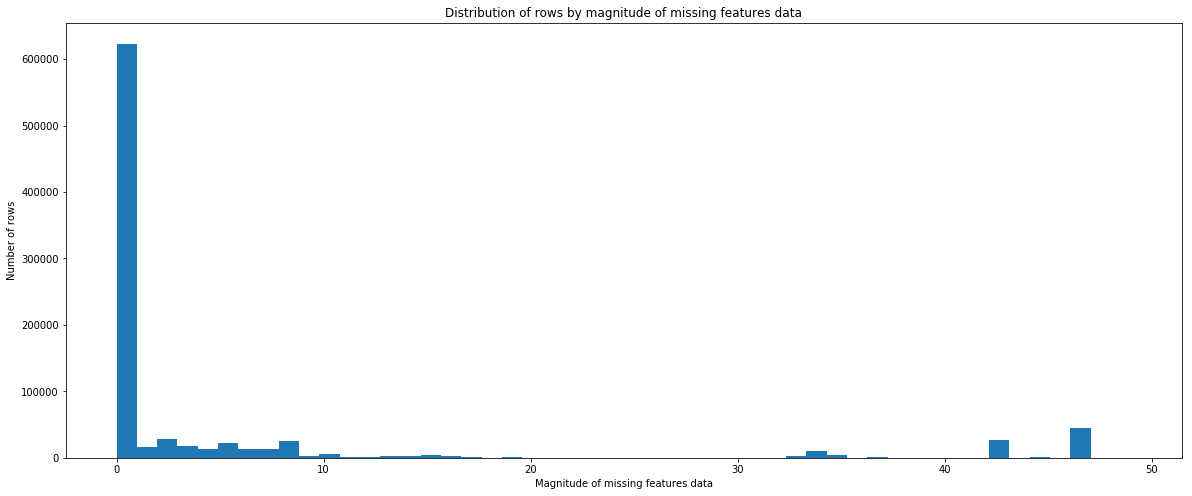

In [26]:
# Visual of distribution of rows with any missing data
plt.hist(totals_rows_w_missing_data, bins=50)

plt.title('Distribution of rows by magnitude of missing features data')
plt.xlabel('Magnitude of missing features data')
plt.ylabel('Number of rows')
plt.rcParams["figure.figsize"] = [20,8]
plt.show()

In [27]:
# For analysis purposes, create a separate dataframe
df_totals_rows_w_missing_data = pd.DataFrame(totals_rows_w_missing_data)

# Rename initial column to missing_data_count (ie. for a given row, how many features having missing data)
df_totals_rows_w_missing_data.columns=['missing_data_count']

# Add in a dummy row_counter column
df_totals_rows_w_missing_data['row_counter'] = 1

# Quick look at the analysis dataframe
df_totals_rows_w_missing_data.head()

,missing_data_count,row_counter
0,43,1
1,0,1
2,0,1
3,7,1
4,0,1


In [28]:
# A cumulative view of the percentage of data that will be retained, as we move from rows without missing data
# to rows witth increasing missing data
df_totals_rows_w_missing_data_grouped = df_totals_rows_w_missing_data.groupby('missing_data_count')['row_counter'].sum().cumsum() / df_totals_rows_w_missing_data.shape[0] * 100

In [29]:
# Quick top 30 view of cumulative percentage of data retained sorted by an increasing number of missing data per record
df_totals_rows_w_missing_data_grouped.head(n=30)

missing_data_count
0     69.927549
1     71.693441
2     74.826895
3     76.804968
4     78.219544
5     80.745853
6     82.291037
7     83.829824
8     86.589185
9     86.930514
10    87.537547
11    87.664003
12    87.749952
13    88.115181
14    88.366859
15    88.899050
16    89.180125
17    89.256088
18    89.304112
19    89.436515
20    89.475674
21    89.492505
22    89.506980
23    89.521791
24    89.529533
25    89.535704
26    89.542325
27    89.545017
28    89.545578
29    89.546925
Name: row_counter, dtype: float64

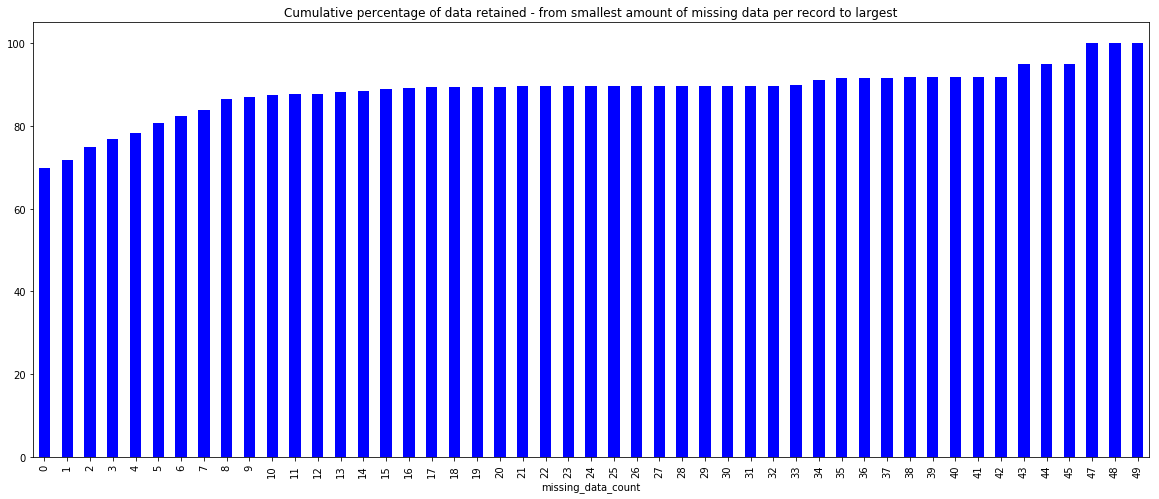

In [30]:
# Graph view of cumulative percentage of data retained sorted by an increasing number of missing data per record
df_totals_rows_w_missing_data_grouped.plot.bar(color = 'blue', 
                                               title = 'Cumulative percentage of data retained - from smallest amount of missing data per record to largest');

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Based on the analysis above, we will define 2 subsets:
# - Minor_missing_val = Records with <= 15 missing feature data per record --> covers 88.899049730650432% of data
# - Major_missing_val = Records with > 15 missing feature data per record --> covers 11.100950269349568% of data

# Define the record index for both subsets
minor_missing_records = df_totals_rows_w_missing_data[df_totals_rows_w_missing_data['missing_data_count'] <=15]
major_missing_records = df_totals_rows_w_missing_data[df_totals_rows_w_missing_data['missing_data_count'] >15]

# Populate both subsets
azdias_processed_02_minor_missing_val = azdias_processed_02.iloc[minor_missing_records.index,:]
azdias_processed_02_major_missing_val = azdias_processed_02.iloc[major_missing_records.index,:]

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

zero_missing_feature_data = pct_missing_per_column[pct_missing_per_column==0].index.tolist()

# Quick view of features where there are zero missing feature data
zero_missing_feature_data

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [33]:
# Multiple ways to choose features for comparison:

# -------------------------------------------------------------------------------------------
# Method 1: Top 5 feature selector
# comparison_features = zero_missing_feature_data[:15]

# -------------------------------------------------------------------------------------------
# Method 2: Random feature selector 
# comparison_features = np.random.choice(zero_missing_feature_data, 5).tolist()

# -------------------------------------------------------------------------------------------
# Method 3: Select features for each feature type - from a pool of features 
#           where there are zero missing feature data

# 1. Person-level features = 'ANREDE_KZ' (Gender), 'FINANZ_MINIMALIST', 'FINANZ_SPARER' (Financial typology), 
#                            'SEMIO_SOZ', 'SEMIO_FAM' (Personality typology), 'ZABEOTYP' (Energy consumption typology)
# 2. Household-level features = NA
# 3. Building-level features = NA
# 4. RR4 micro-cell features = NA
# 5. RR3 micro-cell features = NA
# 6. Postcode-level features = NA
# 7. RR1 neighborhood features = NA
# 8. PLZ8 macro-cell features = NA
# 9. Community-level features = NA
#
# Interestingly, only Person-level features are present in this pool.
comparison_features = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'SEMIO_SOZ', 'SEMIO_FAM', 'ZABEOTYP']

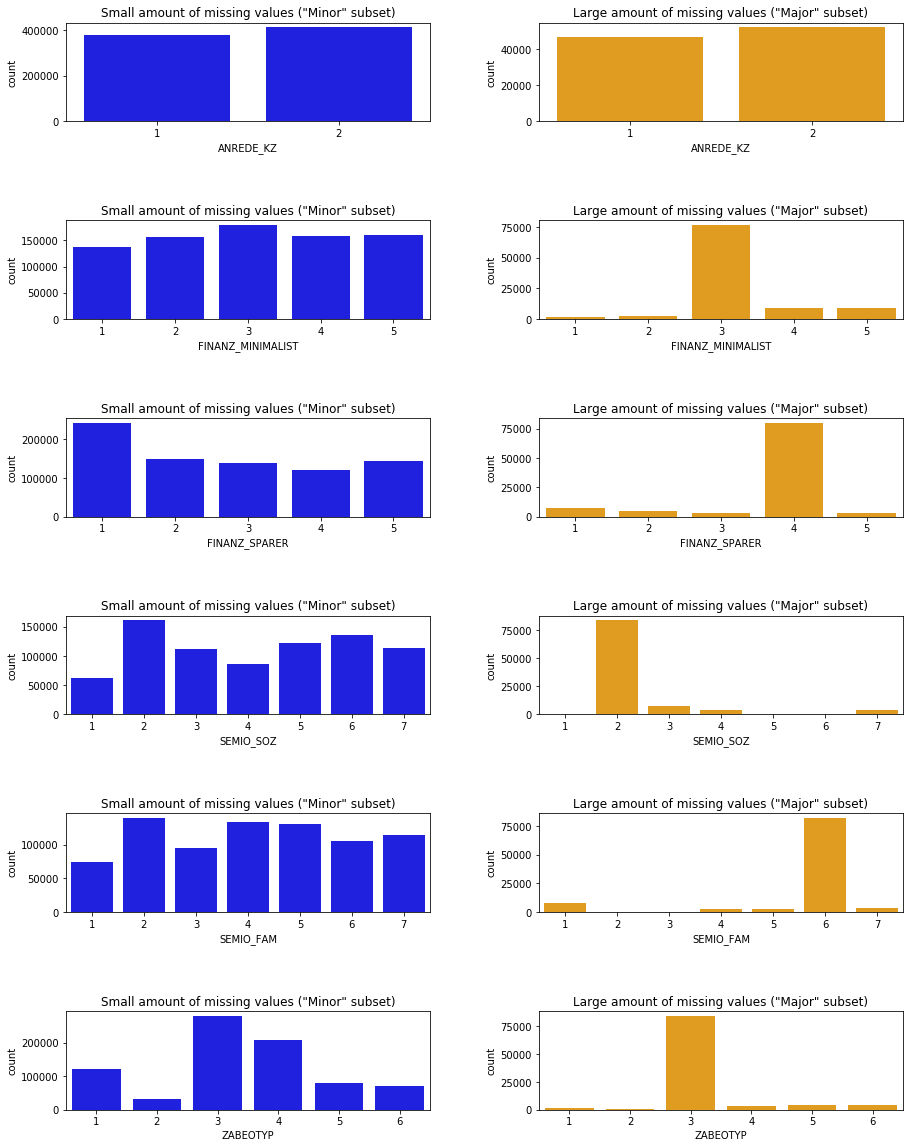

In [34]:
figure, axs = plt.subplots(nrows=len(comparison_features), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(comparison_features)):
    sns.countplot(azdias_processed_02_minor_missing_val[comparison_features[i]], ax=axs[i][0], color='blue')
    axs[i][0].set_title('Small amount of missing values ("Minor" subset)')
    sns.countplot(azdias_processed_02_major_missing_val[comparison_features[i]], ax=axs[i][1], color='orange')
    axs[i][1].set_title('Large amount of missing values ("Major" subset)')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Based on the analysis above, we will have defined 2 subsets:
 - Minor_missing_val (aka. Minor missing value subset) = Records with <= 15 missing feature data per record --> covers 88.90% of data
 - Major_missing_val (aka. Major missing value subset) = Records with > 15 missing feature data per record --> covers 11.10% of data

##### Observations
We chose 6 'Person-level features' for comparison between the Minor and Major subsets, and made the following observations:
 - Gender (ANREDE_KZ) ==> Distribution of feature values are similar, the pattern persists regardless of the magnitude of missing data. Hence, data is qualitatively similar.
 - Financial typology (FINANZ_MINIMALIST, FINANZ_SPARER) ==> Distribution of feature values are different. In the dataset with minimal missing data, there is a more even distribution of record over feature values. In the dataset with large magnitude of missing data, there are clearly dominant feature values. Hence, data is qualitatively different.  
 - Personality typology (SEMIO_SOZ, SEMIO_FAM) ==> The observations in Financial typology applies to Personality typology. Data is qualitatively different.
 - Energy consumption typology (ZABEOTYP) ==> The observations in Financial typology applies to Personality typology. Data is qualitatively different.

Overall, it can be observed that data is qualitatively different between the data set with minimal missing values compared to data set with high magnitude of missing values. 

The decision has been made to remove records with > 15 missing feature data from the analysis. We will only be keeping records witth minor missing values. We will accept the risk of excluding certain members of the population.

In [35]:
# Create a new cleaner data set
azdias_processed_03 = azdias_processed_02_minor_missing_val
print('Total records moving to next part of process: {}'.format(azdias_processed_03.shape[0]))

# Clearly group the records deleted
azdias_excluded_data = azdias_processed_02_major_missing_val
print('Total records excluded from next part of process: {}'.format(azdias_excluded_data.shape[0]))

Total records moving to next part of process: 792287
Total records excluded from next part of process: 98934


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?

# Identify list of features from records with minimal missing feature data
features = list(azdias_processed_03.columns)

# Identify the feature type for selected list of features
feat_info_selected = feat_info[feat_info['attribute'].isin(features)]
feat_data_type_count = feat_info_selected['type'].value_counts()

# Shows the number of features by feature type
feat_data_type_count

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [38]:
# Look at the categorical features
categ_features = feat_info_selected[feat_info_selected['type'] == 'categorical']
categ_features

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [39]:
# Split the categorical features into: binary and multi-level 

# Define empty lists
binary_features = []
multi_level_features = []

# Perform split
for feature in categ_features['attribute']:
    if (len(azdias_processed_03[feature].unique())==2):
        binary_features.append(feature)
    elif (len(azdias_processed_03[feature].unique())>2):
        multi_level_features.append(feature)

In [40]:
# List of binary features
binary_features

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [41]:
# List of multi level features
multi_level_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [43]:
# For binary features, identify the features with non-numeric values

for feature in binary_features:
    print('{}: Unique values are {}'.format(feature, azdias_processed_03[feature].unique()))

ANREDE_KZ: Unique values are [2 1]
GREEN_AVANTGARDE: Unique values are [0 1]
SOHO_KZ: Unique values are [ 1.  0.]
OST_WEST_KZ: Unique values are ['W' 'O']


In [44]:
# Re-encode binary features with non-numeric values (OST_WEST_KZ)

new_encoded_value = {'W': 0, 'O': 1}
azdias_processed_03 = azdias_processed_03.replace({'OST_WEST_KZ':new_encoded_value})

In [45]:
# Treat multi level features - by dropping them for simplicity

for feature in multi_level_features:
    azdias_processed_03 = azdias_processed_03.drop(feature, axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

The below treatments were done for the categorical features.

##### Binary features
 - The 3 Numeric binary features were kept and unmodified
 - The 1 Non-numeric binary feature (OST_WEST_KZ) was re-encoded to make it a numeric binary feature
 
##### Multi level features
 - To reduce complexity, all 15 multi level features were dropped


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# The 2 new variables: 'DECADE', 'MOVEMENT'

# -----------------------------------------------------------------------------
# Engineering 'DECADE' variable
azdias_processed_03['DECADE'] = azdias_processed_03['PRAEGENDE_JUGENDJAHRE']

# Define conversions
decade_conversion_dict = {1:1, 2:1, 
                           3:2, 4:2, 
                           5:3, 6:3, 7:3, 
                           8:4, 9:4, 
                           10:5, 11:5, 12:5, 13:5, 
                           14:6, 15:6}

# Perform conversion
azdias_processed_03['DECADE'].replace(decade_conversion_dict, inplace=True)

# -----------------------------------------------------------------------------
# Engineering 'MOVEMENT' variable
azdias_processed_03['MOVEMENT'] = azdias_processed_03['PRAEGENDE_JUGENDJAHRE']

# Define conversions
movement_conversion_dict = {1:1, 
                            2:0, 
                            3:1, 
                            4:0, 
                            5:1, 
                            6:0, 7:0, 
                            8:1, 
                            9:0, 
                            10:1, 
                            11:0, 
                            12:1, 
                            13:0, 
                            14:1, 
                            15:0}

# Perform conversion
azdias_processed_03['MOVEMENT'].replace(movement_conversion_dict, inplace=True)

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# The 2 new variables: 'WEALTH', 'LIFE_STAGE'

# -----------------------------------------------------------------------------
# Engineering 'DECADE' variable
azdias_processed_03['WEALTH'] = azdias_processed_03['CAMEO_INTL_2015']

# Define conversions
wealth_conversion_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                          '21':2, '22':2, '23':2, '24':2, '25':2,
                          '31':3, '32':3, '33':3, '34':3, '35':3, 
                          '41':4, '42':4, '43':4, '44':4, '45':4,
                          '51':5, '52':5, '53':5, '54':5, '55':5}

# Perform conversion
azdias_processed_03['WEALTH'].replace(wealth_conversion_dict, inplace=True)

# -----------------------------------------------------------------------------
# Engineering 'MOVEMENT' variable
azdias_processed_03['LIFE_STAGE'] = azdias_processed_03['CAMEO_INTL_2015']

# Define conversions
life_stage_conversion_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, 
                              '21':1, '22':2, '23':3, '24':4, '25':5,
                              '31':1, '32':2, '33':3, '34':4, '35':5, 
                              '41':1, '42':2, '43':3, '44':4, '45':5,
                              '51':1, '52':2, '53':3, '54':4, '55':5}

# Perform conversion
azdias_processed_03['LIFE_STAGE'].replace(life_stage_conversion_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Features kept
These 2 mixed-type features are retained and broken into 2 variables respectively:
 - PRAEGENDE_JUGENDJAHRE ==> New variables created:'DECADE', 'MOVEMENT'
 - CAMEO_INTL_2015 ==> New variables created: 'WEALTH', 'LIFE_STAGE'

##### Steps taken to engineer new variables from mixed-type features
The following steps we followed for each mixed-type feature:
 - Step 1: Create new columns for new variables and fill them with the values of the mixed-type features
 - Step 2: Define the conversion - what we do we want to replace the original feature values with
 - Step 3: Within each new column, replace the original copied feature values with defined conversion values
 
##### Features dropped
The remaining 4 mixed-type features will be dropped for simplicity:
 - LP_LEBENSPHASE_FEIN
 - LP_LEBENSPHASE_GROB
 - WOHNLAGE
 - PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Remove all the mixed-type features. 
# We have already engineered the new variables from the 2 selected features (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015).
# Therefore, we can now remove all these mixed-type features.

mixed_features = feat_info_selected[feat_info_selected["type"]=="mixed"]["attribute"]
for feature in mixed_features:
    azdias_processed_03.drop(feature, axis=1, inplace=True)

In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Create a new cleaned data set
azdias_processed_final = azdias_processed_03

# Quick look at final, cleaned data set and it's shape
print(azdias_processed_final.shape)
azdias_processed_final.head()

(792287, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # -----------------------------------------------------------------------------
    # PART 1: convert missing value codes into NaNs, ... 
    # -----------------------------------------------------------------------------
    # ==> using 'convert_missing_unknown_to_nan' function
    df01 = convert_missing_unknown_to_nan(df)
    
    # -----------------------------------------------------------------------------
    # PART 2: remove selected columns and rows, ...
    # -----------------------------------------------------------------------------
    # ==> PART 2.1: Remove columns with >= 20% missing data
    # -----------------------------------------------------------------------------
    selected_drop_features = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df02 = df01.drop(selected_drop_features, axis=1)

    # -----------------------------------------------------------------------------
    # ==> PART 2.2: Keep rows with <= 15 missing feature values
    # -----------------------------------------------------------------------------         
    df02 = df02[df02.isnull().sum(axis=1) <= 15]
        
    # -----------------------------------------------------------------------------
    # PART 3: select, re-encode, and engineer column values.
    # -----------------------------------------------------------------------------
    # ==> PART 3.1: Re-encode binary features with non-numeric values (OST_WEST_KZ)
    # -----------------------------------------------------------------------------
    new_encoded_value = {'W': 0, 'O': 1}
    df03 = df02.replace({'OST_WEST_KZ':new_encoded_value})
    
    # -----------------------------------------------------------------------------
    # ==> PART 3.2: Treat multi level features - by dropping them for simplicity 
    # -----------------------------------------------------------------------------
    # Look at the categorical features
    categ_features = feat_info_selected[feat_info_selected['type'] == 'categorical']   

    # Define empty list
    multi_level_features = []

    # Idenfity multi-level categorical features
    for feature in categ_features['attribute']:
        if (len(df03[feature].unique())>2):
            multi_level_features.append(feature)

    # Drop multi-level categorical features
    for feature in multi_level_features:
        df03 = df03.drop(feature, axis = 1)
            
    # -----------------------------------------------------------------------------
    # ==> PART 3.3: Engineer new variables from selected mixed-type features
    # -----------------------------------------------------------------------------
    # Using "PRAEGENDE_JUGENDJAHRE" as base, engineer two new variables.
    # The 2 new variables: 'DECADE', 'MOVEMENT'
    # -----------------------------------------------------------------------------
    # Engineering 'DECADE' variable
    df03['DECADE'] = df03['PRAEGENDE_JUGENDJAHRE']

    # Define conversions
    decade_conversion_dict = {1:1, 2:1, 
                               3:2, 4:2, 
                               5:3, 6:3, 7:3, 
                               8:4, 9:4, 
                               10:5, 11:5, 12:5, 13:5, 
                               14:6, 15:6}

    # Perform conversion
    df03['DECADE'].replace(decade_conversion_dict, inplace=True)
    # -----------------------------------------------------------------------------
    # Engineering 'MOVEMENT' variable
    df03['MOVEMENT'] = df03['PRAEGENDE_JUGENDJAHRE']

    # Define conversions
    movement_conversion_dict = {1:1, 
                                2:0, 
                                3:1, 
                                4:0, 
                                5:1, 
                                6:0, 7:0, 
                                8:1, 9:0, 
                                10:1, 
                                11:0, 
                                12:1, 
                                13:0, 
                                14:1, 
                                15:0}

    # Perform conversion
    df03['MOVEMENT'].replace(movement_conversion_dict, inplace=True)
    
    # -----------------------------------------------------------------------------
    # Using "CAMEO_INTL_2015" as base, engineer two new variables.   
    # The 2 new variables: 'WEALTH', 'LIFE_STAGE'
    # -----------------------------------------------------------------------------
    # Engineering 'DECADE' variable
    df03['WEALTH'] = df03['CAMEO_INTL_2015']

    # Define conversions
    wealth_conversion_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                              '21':2, '22':2, '23':2, '24':2, '25':2,
                              '31':3, '32':3, '33':3, '34':3, '35':3, 
                              '41':4, '42':4, '43':4, '44':4, '45':4,
                              '51':5, '52':5, '53':5, '54':5, '55':5}

    # Perform conversion
    df03['WEALTH'].replace(wealth_conversion_dict, inplace=True)

    # -----------------------------------------------------------------------------
    # Engineering 'MOVEMENT' variable
    df03['LIFE_STAGE'] = df03['CAMEO_INTL_2015']

    # Define conversions
    life_stage_conversion_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, 
                                  '21':1, '22':2, '23':3, '24':4, '25':5,
                                  '31':1, '32':2, '33':3, '34':4, '35':5, 
                                  '41':1, '42':2, '43':3, '44':4, '45':5,
                                  '51':1, '52':2, '53':3, '54':4, '55':5}

    # Perform conversion
    df03['LIFE_STAGE'].replace(life_stage_conversion_dict, inplace=True)    
        
    # -----------------------------------------------------------------------------    
    # ==> PART 3.4: Drop mixed-type features
    # -----------------------------------------------------------------------------
    # Drop all mixed-type features    
    mixed_features = feat_info_selected[feat_info_selected["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        df03.drop(feature, axis=1, inplace=True)
    
    df_final = df03
    
    # -----------------------------------------------------------------------------
    # PART 4: Return the cleaned dataframe.
    # -----------------------------------------------------------------------------       
    return df_final

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Check the data set shape prior to imputation and scaling
print(azdias_processed_final.shape)

(792287, 63)


In [52]:
# Prepare a data set for impuation of NaN feature values
azdias_processed_final_imputed = azdias_processed_final

In [53]:
# Impute NaNs using 'mode'/'most frequent' value
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias_processed_final_imputed = imputer.fit_transform(azdias_processed_final_imputed)
azdias_processed_final_imputed = pd.DataFrame(azdias_processed_final_imputed, columns=list(azdias_processed_final))

# Check the data set shape to ensure it remains the same
print(azdias_processed_final_imputed.shape)

# Quick look at imputed data set
azdias_processed_final_imputed.head()

(792287, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [54]:
# Apply feature scaling to the general population demographics data.

In [55]:
# Prepare a data set for scaling feature values
azdias_processed_final_imputed_scaled = azdias_processed_final_imputed

In [56]:
# Perform standard scaling
scaler = StandardScaler()
azdias_processed_final_imputed_scaled = scaler.fit_transform(azdias_processed_final_imputed_scaled)
azdias_processed_final_imputed_scaled = pd.DataFrame(azdias_processed_final_imputed_scaled, 
                                                     columns=list(azdias_processed_final))

# Check the data set shape to ensure it remains the same
print(azdias_processed_final_imputed_scaled.shape)

# Quick look at scaled data set
azdias_processed_final_imputed_scaled.head()

(792287, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766833,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.009006,-1.683960,0.440059,-0.058275,0.003859,-0.460231,-1.685032,-1.113476,-1.436810,-0.579923,1.274992,-0.310505,1.338258,-0.157980,1.514616,1.289262,10.858566,0.232515,-0.060609,1.021344,-0.731599,0.56174,0.170588,-0.125269,-1.302785,-0.386123,-0.517873,-1.015918,-0.972148,-0.597661,2.719961,-1.654391,0.846083,-0.549265,1.702316,-0.798845,-0.788499,-1.291504,0.170190,-0.877546,0.964446,-0.257286,0.212581,0.404354,0.435807,1.448637,0.570403,-0.173897,-0.128877,0.683117,1.101106,0.531050,1.176521,-1.251616
1,0.200034,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.009006,-0.310091,-0.075037,-1.627676,-0.519627,-0.460231,-0.140791,-0.162289,0.753219,-0.579923,0.065584,1.397993,1.338258,1.447682,-0.636320,-0.410816,-0.092093,-0.631531,-0.060609,-0.274332,-0.731599,0.56174,0.106751,-0.125269,1.277170,-0.386123,-0.517873,-0.304983,1.437769,0.403064,-0.466013,-0.116549,-0.985359,0.032548,-0.269605,0.285141,-0.788499,0.084154,-0.473131,-1.429793,0.242104,0.782549,0.212581,-0.618844,-0.940896,0.414633,0.570403,-0.173897,-0.128877,-0.791142,1.101106,-1.883063,-0.869341,0.764647
2,1.183468,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.313245,-0.997025,0.440059,-1.627676,-1.043114,-1.505335,-0.140791,-0.162289,1.300726,-0.069114,-0.539120,-0.310505,-0.304993,0.377241,-0.098586,0.155877,-0.092093,-1.495577,-0.060609,-2.217846,0.956751,0.56174,-0.467779,-0.125269,0.632182,1.270958,-0.517873,1.827822,-0.168842,-0.597661,-0.466013,0.652372,-0.069638,-1.131077,0.716355,0.285141,0.270188,0.771983,-1.116452,0.779192,-0.091727,-0.257286,-0.885967,0.404354,-0.940896,-0.619371,0.570403,-1.176336,-0.999582,-0.054012,-0.264630,0.531050,-1.551294,-0.579528
3,0.200034,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.009006,1.063779,0.955155,-0.058275,0.003859,-0.982783,1.403449,-0.162289,-0.341796,0.952503,-1.143823,-0.880004,-1.400493,-1.228422,-0.098586,-0.977508,-0.092093,1.960608,-0.060609,0.373506,-1.294382,0.56174,-0.340106,-0.125269,0.632182,-0.386123,-0.517873,-0.304983,2.241075,0.403064,-0.466013,-0.116549,-0.985359,0.614360,-1.748545,1.369127,0.270188,0.084154,1.456833,0.226946,-0.555062,-0.257286,1.311128,0.404354,0.435807,-0.619371,-0.338352,0.828542,0.306475,1.420247,-0.264630,0.531050,0.494567,0.092559
4,-1.766833,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.009006,-0.310091,-1.105229,-0.058275,1.574319,0.062321,-1.170285,-1.113476,-1.436810,0.441694,1.879696,-0.310505,-0.304993,-0.157980,1.514616,1.289262,-0.092093,-0.631531,-0.060609,0.373506,0.956751,0.56174,-0.212433,-0.125269,1.277170,-0.386123,-0.517873,0.405952,0.634464,-0.597661,-0.466013,0.652372,0.846083,-1.131077,1.209336,0.285141,1.328875,0.771983,-1.116452,0.226946,1.934283,-0.257286,0.212581,-0.618844,0.435807,1.448637,1.479158,-1.176336,-0.999582,-0.054012,-1.630367,0.531050,1.176521,0.764647


### Discussion 2.1: Apply Feature Scaling

2 forms of feature scaling were performed
##### Imputation of NaN values
 - Instead of deleting all rows which had any instance of NaN feature values which would result in removing a substantial number of records, we have decided to keep it and perform imputation. It was decided to replace the NaN feature values with the mode/most frequent value using the imputer.

##### Standard scaling of feature values
 - The features are then scaled using a standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_processed_final_imputed_scaled)

In [58]:
# Investigate the variance accounted for by each principal component.

# Quick look
pca.explained_variance_ratio_

array([  1.68746879e-01,   1.35263059e-01,   9.61516168e-02,
         5.37675896e-02,   3.78526701e-02,   3.22580471e-02,
         2.85620545e-02,   2.52278767e-02,   2.22017967e-02,
         2.20140350e-02,   2.14368814e-02,   1.90244252e-02,
         1.86288520e-02,   1.78504658e-02,   1.69839424e-02,
         1.62369710e-02,   1.58664006e-02,   1.48991679e-02,
         1.34268725e-02,   1.30982639e-02,   1.24990169e-02,
         1.20316147e-02,   1.16323251e-02,   1.08471202e-02,
         1.00688449e-02,   8.06543698e-03,   7.77997602e-03,
         7.50938088e-03,   7.23744854e-03,   6.87375881e-03,
         6.61243845e-03,   6.46794503e-03,   6.39020401e-03,
         6.16716685e-03,   5.91656979e-03,   5.62103160e-03,
         5.05321546e-03,   4.92348490e-03,   4.67842936e-03,
         4.41121685e-03,   4.17766454e-03,   3.96119923e-03,
         3.89614656e-03,   3.86258244e-03,   3.67183358e-03,
         3.57426969e-03,   3.31854437e-03,   3.15213091e-03,
         3.11708725e-03,

In [59]:
# Create function to generate scree_plot
def gen_scree_plot(pca):
    values = pca.explained_variance_ratio_

    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=(20,15))
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    
    ax.bar(ind, values, color = 'b')
    ax.plot(ind, cumvalues, color='b')
    
    # Data point labels - Variance explained per principle component
    for i in range(n_components):
        ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                    (ind[i]+0.2, values[i]),
                    va="bottom",
                    ha="center",
                    fontsize=10,
                   rotation='vertical')
        
    # Data point labels - Cumulative Variance explained across principle component
    for i in range(n_components):
        ax.annotate(r"%s%%" % ((str(cumvalues[i]*100)[:4])), 
                    (ind[i]+0.2, cumvalues[i]),
                    va="bottom",
                    ha="center",
                    fontsize=10,
                   rotation='vertical')        

    # Generate 80% and 90% variance explained - reference lines in red    
    plt.hlines(y=0.8, xmin=0, xmax=20, color='r', linestyles='dashed',zorder=1)
    plt.vlines(x=20, ymin=0, ymax=0.8, color='r', linestyles='dashed',zorder=2)    
    plt.text(10, 0.82, ' Ref line: 80% cumul variance', ha='right', va='center', color = 'r')

    plt.hlines(y=0.9, xmin=0, xmax=31, color='r', linestyles='dashed',zorder=1)
    plt.vlines(x=31, ymin=0, ymax=0.9, color='r', linestyles='dashed',zorder=2)    
    plt.text(10, 0.92, ' Ref line: 90% cumul variance', ha='right', va='center', color = 'r')    
    
    ax.set_xlabel("Principal Component count", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    plt.title("Explained Variance Per Principle Component", fontsize=18);
    

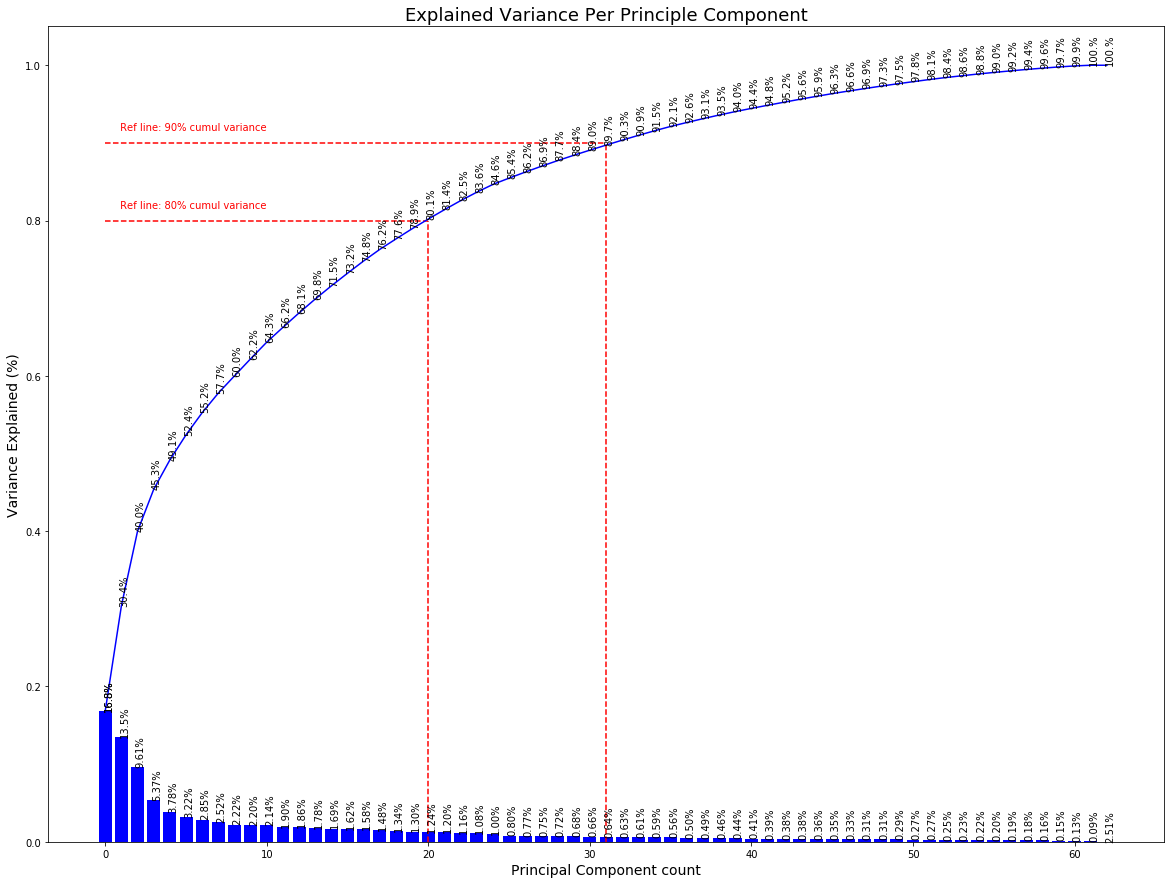

In [60]:
# Graphing the variance accounted for by each principal component
gen_scree_plot(pca)

In [61]:
# Observing the scree_plot above, we can see that:
# - Having 20 principle components enable us to explain 80% of variance
# - Having 31 principle components enable us to explain 90% of variance

# Therefore, I've decided to select 31 principle components
# ----------------------------------------------------------------------------

# Re-apply PCA to the data while selecting for number of components to retain.
pca_31 = PCA(n_components = 31)
azdias_pca_31 = pca_31.fit_transform(azdias_processed_final_imputed_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

##### Observations
Observing the scree_plot above, we can see that:
 - Having 20 principle components enable us to explain 80% of variance
 - Having 31 principle components enable us to explain 90% of variance
 
##### Decision
Therefore, I've decided to select 31 principle components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first, second, third principal components to corresponding feature names
# and then print the linked values, sorted by weight.

# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Creating a reusable pca weights function
def view_pca_weights(pca, principal_component, count_of_weights_presented_topbottom):
    
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(4)
    ratio.index = dimensions
    
    weights = pd.DataFrame(pca.components_, columns=list(azdias_processed_final_imputed_scaled.columns))
    weights = weights.round(4)
    weights.index = dimensions
    
    result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
    result[:5]
    print("Principal Component number ", (principal_component))
    
    print('-' * 30)
    print('Top {} positive weights -->'.format(count_of_weights_presented_topbottom))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:count_of_weights_presented_topbottom])
    
    print('-' * 30)
    print('Top {} negative weights -->'.format(count_of_weights_presented_topbottom))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=True)[:count_of_weights_presented_topbottom])


In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

view_pca_weights(pca_31, principal_component = 1, count_of_weights_presented_topbottom = 5)

Principal Component number  1
------------------------------
Top 5 positive weights -->
------------------------------
PLZ8_ANTG3            0.2251
PLZ8_ANTG4            0.2170
WEALTH                0.2049
HH_EINKOMMEN_SCORE    0.2025
ORTSGR_KLS9           0.1963
Name: PC 1, dtype: float64
------------------------------
Top 5 negative weights -->
------------------------------
MOBI_REGIO          -0.2261
PLZ8_ANTG1          -0.2254
FINANZ_MINIMALIST   -0.2230
KBA05_GBZ           -0.2158
KBA05_ANTG1         -0.2152
Name: PC 1, dtype: float64


In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

view_pca_weights(pca_31, principal_component = 2, count_of_weights_presented_topbottom = 5)

Principal Component number  2
------------------------------
Top 5 positive weights -->
------------------------------
ALTERSKATEGORIE_GROB    0.2565
SEMIO_ERL               0.2299
FINANZ_VORSORGER        0.2290
SEMIO_LUST              0.1798
RETOURTYP_BK_S          0.1621
Name: PC 2, dtype: float64
------------------------------
Top 5 negative weights -->
------------------------------
SEMIO_REL       -0.2539
DECADE          -0.2390
FINANZ_SPARER   -0.2317
SEMIO_TRADV     -0.2280
SEMIO_PFLICHT   -0.2258
Name: PC 2, dtype: float64


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

view_pca_weights(pca_31, principal_component = 3, count_of_weights_presented_topbottom = 5)

Principal Component number  3
------------------------------
Top 5 positive weights -->
------------------------------
SEMIO_VERT           0.3451
SEMIO_SOZ            0.2623
SEMIO_FAM            0.2490
SEMIO_KULT           0.2336
FINANZ_MINIMALIST    0.1547
Name: PC 3, dtype: float64
------------------------------
Top 5 negative weights -->
------------------------------
ANREDE_KZ    -0.3675
SEMIO_KAEM   -0.3353
SEMIO_DOM    -0.3130
SEMIO_KRIT   -0.2746
SEMIO_RAT    -0.2175
Name: PC 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

Observations and interpretations of the first 3 principal components (focusing on the top 5 positive and top 5 negative weights) can be found below:

##### Principal component 1
Top 5 weights:
- PLZ8_ANTG3 -->            0.2251 (Number of 6-10 family houses in PLZ8 region)
- PLZ8_ANTG4 -->            0.2170 (Number of 10+ family houses in PLZ8 region)
- WEALTH -->                0.2049 (Positive means likely to be wealthy)
- HH_EINKOMMEN_SCORE -->    0.2025 (Estimated household net income)
- ORTSGR_KLS9 -->           0.1963 (Size of community)

Bottom 5 weights:
- MOBI_REGIO -->          -0.2261 (Movement patterns)
- PLZ8_ANTG1 -->          -0.2254 (Number of 1-2 family houses in the PLZ8 region)
- FINANZ_MINIMALIST -->   -0.2230 (Low financial interest)
- KBA05_GBZ -->           -0.2158 (Number of buildings in the microcell)
- KBA05_ANTG1 -->         -0.2152 (Number of 1-2 family houses in the microcell)

Interpretation:
- This component places a high weight on the number of properties owned in the region, financial levels (in terms of income earned and interest) and the community size and density.  

##### Principal component 2
Top 5 weights:
- ALTERSKATEGORIE_GROB -->   0.2565 (Estimated age based on given name analysis)
- SEMIO_ERL -->              0.2299 (Event-oriented)
- FINANZ_VORSORGER -->       0.2290 (Financial typology: Be prepared)
- SEMIO_LUST -->             0.1798 (Sensual-minded)
- RETOURTYP_BK_S -->         0.1621 (Returns made on purchases type: more positive means more likely to return purchases)

Bottom 5 weights:
- SEMIO_REL -->      -0.2539 (Religious)
- DECADE -->         -0.2390 (Decade of birth, more negative means they are older)
- FINANZ_SPARER -->  -0.2317 (Financial typology: Money-saver)
- SEMIO_TRADV -->    -0.2280 (Traditional-minded)
- SEMIO_PFLICHT -->  -0.2258 (Dutiful)

Interpretation:
- This component places a high weight on age and personality (specifically whether individuals are drawn to events, romance, and whether they are religious, traditional and responsible). It looks at people's financial tendency towards saving and their purchasing tendencies. 

##### Principal component 3
Top 5 weights:
- SEMIO_VERT -->          0.3451 (dreamful)
- SEMIO_SOZ -->           0.2623 (socially-minded)
- SEMIO_FAM -->           0.2490 (family-minded)
- SEMIO_KULT -->          0.2336 (cultural-minded)
- FINANZ_MINIMALIST -->   0.1547 (Low financial interest)

Bottom 5 weights:
- ANREDE_KZ -->   -0.3675 (Gender - more negative means more likely male)
- SEMIO_KAEM -->  -0.3353 (combative attitude)
- SEMIO_DOM -->   -0.3130 (dominant-minded)
- SEMIO_KRIT -->  -0.2746 (critical-minded)
- SEMIO_RAT -->   -0.2175 (rational)

Interpretation:
- This component places high weight on personality (whether they are dreamers, social, family, cultural, combative, dominant, or critical minded). It looks at their gender and also their financial mindset.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
# Create a function to calculate K-Means
def get_kmeans_score(data, n_clusters):
    
    # Start K-Means
    kmeans = KMeans(n_clusters)
    
    # Fit model to input data
    model = kmeans.fit(data)
    
    # Generate a score for the fitted model
    score = np.abs(model.score(data))
    
    return score

In [67]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

# Create storage for model scores
model_scores = []

# Set the range of cluster counts to score
n_clusters_range = list(range(1,20,2))

# ----------------------------------------------------------------
# Run K-Means clustering over a range of scores
# ***Uncomment to run the code --> It will take a while to complete
# ----------------------------------------------------------------
# for n_clusters in n_clusters_range:
#     print('Start scoring for cluster count: {}'.format(n_clusters))
#     model_scores.append(get_kmeans_score(azdias_pca_31, n_clusters))  
#     print('Finish scoring for cluster count: {}'.format(n_clusters))
#     print('-' * 30)
# ----------------------------------------------------------------    

# ----------------------------------------------------------------
# Alternatively, use the model_scores from previous run
# ***Uncomment to use this
# ----------------------------------------------------------------
model_scores = [44443868.21056889,
                 34885465.287376441,
                 31376942.708848111,
                 29003002.595070094,
                 27567087.559979133,
                 26578281.787508629,
                 25523237.313014314,
                 24528865.749331646,
                 24311993.576406356,
                 23341979.074044179]
# ----------------------------------------------------------------

In [68]:
# Quick look at model scores
model_scores

[44443868.21056889,
 34885465.28737644,
 31376942.70884811,
 29003002.595070094,
 27567087.559979133,
 26578281.78750863,
 25523237.313014314,
 24528865.749331646,
 24311993.576406356,
 23341979.07404418]

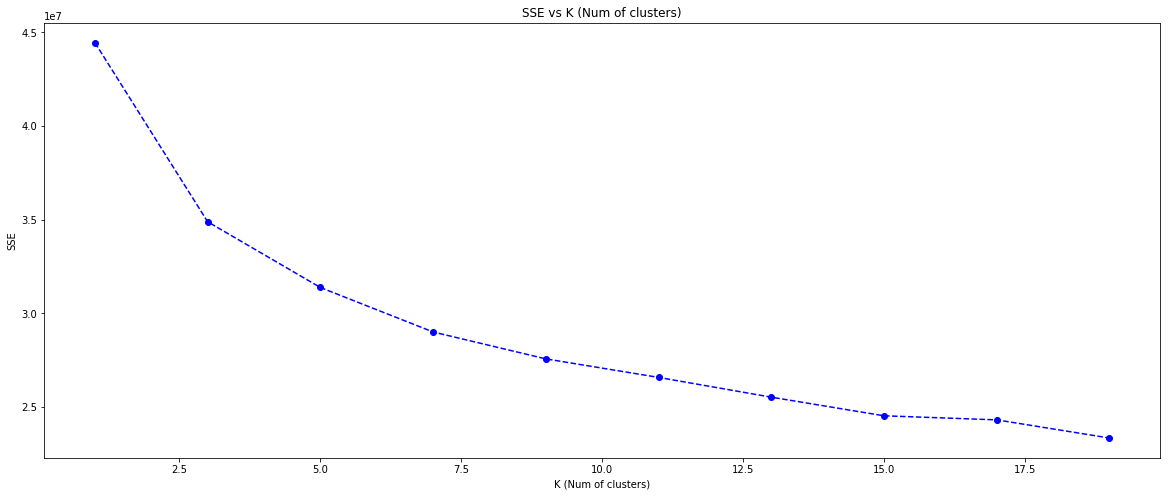

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot model scores
plt.plot(n_clusters_range, model_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K (Num of clusters)');
plt.ylabel('SSE');
plt.title('SSE vs K (Num of clusters)');

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=15)
kmeans_model_n_15 = kmeans.fit(azdias_pca_31)

predict_label_general_data = kmeans_model_n_15.predict(azdias_pca_31)

In [71]:
# Quick look at predicted labels for general data 
print('Total number of final records: {}'.format(predict_label_general_data.shape[0]))
pd.DataFrame(predict_label_general_data).head(n=20)

Total number of final records: 792287


,0
0,4
1,13
2,6
3,14
4,4
5,4
6,9
7,11
8,13
9,5


### Discussion 3.1: Apply Clustering to General Population

##### Observations
Based on the plot above, it looks like the elbow occurs when the cluster count = 15. Beyond this point, the improvement in score diminishes.

##### Decision
Therefore, I've decided to use 15 clusters to segment the population.

In [72]:
# Determine number of excluded general population records
print('Total number of initial population records: {}'.format(azdias.shape[0]))
print('Total number of kept population records: {}'.format(predict_label_general_data.shape[0]))
print('Total number of excluded population records: {}'.format(azdias.shape[0] - predict_label_general_data.shape[0]))

count_records_excluded_from_general_data = azdias.shape[0] - predict_label_general_data.shape[0]

Total number of initial population records: 891221
Total number of kept population records: 792287
Total number of excluded population records: 98934


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Quick look at customer data
customers.shape

(191652, 85)

In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Use 'clean_data' function to clean/processed the customer data
# This function performs the following steps:
# -- Convert missing values to NaN
#
# -- Remove columns with >= 20% missing data
# -- Keep rows with <= 15 missing feature values
#
# -- Re-encode binary features with non-numeric values (OST_WEST_KZ)
# -- Treat multi level features - by dropping them for simplicity
# -- Engineer new variables from selected mixed-type features "PRAEGENDE_JUGENDJAHRE","CAMEO_INTL_2015"
# -- Drop mixed-type features

customers_processed_final = clean_data(customers)

# Quick look at customer data
customers_processed_final.shape

(140898, 63)

In [75]:
# Additional cleaning/processing steps not covered by 'clean_data' function

In [76]:
# Perform imputation to replace NaN feature values
customers_processed_imputed = imputer.transform(customers_processed_final)
customers_processed_imputed = pd.DataFrame(customers_processed_imputed, columns=list(customers_processed_final))

# Check the data set shape to ensure it remains the same
print(customers_processed_imputed.shape)

# Quick look at imputed data set
customers_processed_imputed.head()

(140898, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,4.0,6.0,9.0,1.0,0.0,2.0,1992.0,0.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [77]:
# Perform standard scaling
customers_processed_imputed_scaled = scaler.transform(customers_processed_imputed)
customers_processed_imputed_scaled = pd.DataFrame(customers_processed_imputed_scaled, 
                                                  columns=list(customers_processed_imputed))

# Check the data set shape to ensure it remains the same
print(customers_processed_imputed_scaled.shape)

# Quick look at standard scaled data set
customers_processed_imputed_scaled.head()

(140898, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.183468,-1.043729,1.410658,-1.154259,1.136914,-1.249434,-0.465090,-0.799862,1.883063,-1.635496,1.063779,0.955155,0.464858,-1.043114,1.107425,0.888702,1.264493,-0.889303,-0.069114,-1.748527,-0.880004,-1.948244,-1.763642,-1.174055,-1.544201,-0.092093,0.232515,-0.060609,-2.217846,0.956751,0.56174,-0.467779,-0.125269,1.277170,-0.386123,-0.517873,0.405952,0.634464,-0.597661,-0.466013,0.652372,-0.527498,-1.131077,-0.269605,0.285141,-1.847186,0.771983,0.170190,-1.982039,1.649376,0.782549,0.212581,-0.618844,-0.940896,1.448637,1.479158,-2.178774,-1.434934,-1.528272,-1.630367,-1.883063,-1.551294,0.092559
1,1.183468,0.958103,1.410658,-1.154259,1.136914,-1.249434,0.966060,0.623381,1.883063,-0.313245,1.063779,-1.105229,-1.104542,-1.566601,-0.460231,-0.655538,1.264493,1.300726,-1.601540,-1.143823,1.397993,0.242758,0.912461,-0.098586,-1.544201,-0.092093,-0.631531,-0.060609,-2.217846,0.956751,0.56174,-0.467779,-0.125269,-1.302785,-0.386123,-0.517873,0.405952,0.634464,-0.597661,-0.466013,-0.116549,1.303944,0.032548,-1.748545,-0.798845,0.270188,0.084154,-1.116452,1.331439,-0.560818,-0.257286,0.212581,1.427551,0.435807,-0.619371,-1.247107,-0.173897,-0.128877,-0.054012,-1.630367,-1.883063,-0.187387,0.764647
2,1.183468,-1.043729,1.410658,-1.154259,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.313245,-0.310091,0.955155,0.464858,-0.519627,0.062321,1.403449,0.313305,-0.889303,-0.069114,-0.539120,-0.880004,-0.852743,-0.693201,-0.636320,0.155877,-0.092093,-1.495577,-0.060609,-0.274332,0.956751,0.56174,-0.467779,-0.125269,-0.657796,-0.386123,-0.517873,1.116887,-0.972148,-0.597661,-0.466013,0.652372,1.303944,-1.712890,1.209336,0.285141,0.270188,0.771983,-0.473131,0.779192,0.365852,0.782549,-0.885967,-0.618844,-0.940896,-0.619371,0.570403,-2.178774,-0.999582,-1.528272,-2.313235,0.531050,-0.869341,0.764647
3,0.200034,-1.043729,-0.041079,-1.154259,0.410577,0.787639,1.681635,-0.799862,-0.531050,1.009006,1.063779,-0.075037,0.464858,0.003859,1.107425,0.373955,0.788899,-0.341796,0.441694,0.670288,-0.880004,0.242758,-1.228422,0.439148,0.155877,-0.092093,1.960608,-0.060609,1.021344,-1.294382,0.56174,-0.084759,-0.125269,-1.302785,-0.386123,-0.517873,-1.015918,1.437769,1.403788,-0.466013,-0.116549,-0.527498,0.032548,-0.269605,-0.798845,1.328875,0.084154,1.456833,1.331439,-0.330589,-0.257286,1.311128,0.404354,0.435807,-0.619371,-0.338352,-0.173897,-0.128877,-1.528272,-0.264630,0.531050,0.494567,-1.251616
4,0.200034,-1.043729,1.410658,-1.154259,1.136914,-1.249434,-0.465090,-0.088241,1.883063,1.009006,-0.310091,0.955155,-0.058275,0.003859,-1.505335,1.403449,0.788899,-0.341796,0.952503,-1.143823,0.258994,0.242758,-0.693201,-0.636320,0.155877,-0.092093,0.232515,-0.060609,-2.217846,0.956751,0.56174,-0.467779,-0.125269,-0.657796,-0.386123,-0.517873,0.405952,0.634464,0.403064,-0.466013,-0.116549,1.303944,0.614360,1.702316,0.285141,-0.788499,0.084154,0.170190,-0.877546,1.551529,-0.257286,0.212581,0.404354,0.435807,1.448637,1.479158,-0.173897,0.741828,1.420247,-1.630367,-1.883063,-0.187387,0.764647


In [78]:
# Perform PCA
customers_pca_31 = pca_31.transform(customers_processed_imputed_scaled)
customers_pca_31 = pd.DataFrame(customers_pca_31)

# Check the data set shape to ensure it remains the same
print(customers_pca_31.shape)

# Quick look at data set post PCA
customers_pca_31.head()

(140898, 31)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,-5.902546,0.628545,4.248889,2.194503,-3.099782,0.696660,-1.114236,-1.181631,-0.331064,-0.356394,0.117738,-0.245101,-1.498387,-0.340061,0.191370,0.702976,-0.104293,-0.439323,0.362312,-0.169720,1.308921,0.267035,-0.657125,-0.140255,0.272979,-0.290943,0.003652,-0.886528,-0.953673,-0.795227,0.005483
1,-1.793755,4.797300,-0.631489,2.159951,0.912436,-0.777336,-0.273020,0.603111,-0.300144,-1.637367,0.105289,0.631644,-0.532830,-1.758277,-0.850616,2.015751,0.052718,0.090276,-1.376399,-0.654134,-0.492760,-1.096629,0.137253,-0.442315,0.292940,-0.211929,-1.171302,0.423731,0.477195,-0.367368,0.222384
2,-4.429045,0.204347,2.728652,-2.433806,-1.079463,0.518524,-0.945494,1.248753,-0.644965,-0.360279,0.573398,-0.200452,-0.194844,-0.997710,0.320591,0.926183,-0.000981,1.063453,-0.662916,0.642288,-0.655098,0.551923,0.670150,0.700977,-1.000620,-0.245421,0.046318,1.045679,0.613682,-0.236006,0.153503
3,1.439898,-0.883019,1.175246,-0.615619,0.211872,-1.408417,1.847923,-1.060970,-0.253345,-0.053334,3.664331,0.218149,0.037333,-0.554713,1.225043,0.735149,-0.128949,-0.361892,0.163379,-1.277306,0.453151,-1.138642,0.722616,0.089286,0.318057,0.425194,0.101868,0.531047,-0.103187,-0.782283,0.004259
4,-2.484532,1.163090,2.848699,2.833286,-2.056366,-1.078154,0.309327,-0.392186,0.347937,0.775660,-0.889425,-0.002040,1.253019,0.403150,-2.108054,0.655622,-0.026280,1.608341,-0.802955,-0.256934,-0.979189,-0.405290,0.319091,1.368731,0.393758,-0.735064,-1.105047,0.265069,-0.001565,0.487908,0.069664


In [79]:
# Predict segments using KMeans model with 15 clusters
predict_label_customer_data = kmeans_model_n_15.predict(customers_pca_31)

In [80]:
# Quick look at predicted labels for customer data 
print('Total number of final records: {}'.format(predict_label_customer_data.shape[0]))
pd.DataFrame(predict_label_customer_data).head(n=20)

Total number of final records: 140898


,0
0,11
1,13
2,1
3,14
4,11
5,11
6,11
7,8
8,11
9,11


In [81]:
# Determine number of excluded customer records
print('Total number of initial customer records: {}'.format(customers.shape[0]))
print('Total number of kept customer records: {}'.format(predict_label_customer_data.shape[0]))
print('Total number of excluded customer records: {}'.format(customers.shape[0] - predict_label_customer_data.shape[0]))

count_records_excluded_from_customer_data = customers.shape[0] - predict_label_customer_data.shape[0]

Total number of initial customer records: 191652
Total number of kept customer records: 140898
Total number of excluded customer records: 50754


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [82]:
# Predicted General Population data - grouped by cluster labels
df_predict_label_general_data = pd.DataFrame(predict_label_general_data, columns=['Predicted_Cluster_Label'])
df_predict_label_general_data['Cluster_Label_Instance'] = 1

# Add back deleted rows
df_predict_label_general_data.loc[-1] = [-1, count_records_excluded_from_general_data]

print('Total records: {}'.format(df_predict_label_general_data['Cluster_Label_Instance'].sum()))

df_predict_label_general_data_grouped = df_predict_label_general_data.groupby(['Predicted_Cluster_Label']).sum()

df_predict_label_general_data_grouped['Cluster_Label_Prop'] = ((df_predict_label_general_data_grouped['Cluster_Label_Instance']) / 
                                                                   (df_predict_label_general_data['Cluster_Label_Instance'].sum())*100).round(2)
df_predict_label_general_data_grouped['Data_Scope'] = 'General_population'

df_predict_label_general_data_grouped

Total records: 891221


,Cluster_Label_Instance,Cluster_Label_Prop,Data_Scope
Predicted_Cluster_Label,,,
-1,98934,11.10,General_population
0,59949,6.73,General_population
1,82921,9.30,General_population
2,60475,6.79,General_population
3,37398,4.20,General_population
4,58749,6.59,General_population
5,71814,8.06,General_population
6,77244,8.67,General_population
7,56187,6.30,General_population


In [83]:
# Predicted Customer data - grouped by cluster labels
df_predict_label_customer_data = pd.DataFrame(predict_label_customer_data, columns=['Predicted_Cluster_Label'])
df_predict_label_customer_data['Cluster_Label_Instance'] = 1

# Add back deleted rows
df_predict_label_customer_data.loc[-1] = [-1, count_records_excluded_from_customer_data]

print('Total records: {}'.format(df_predict_label_customer_data['Cluster_Label_Instance'].sum()))

df_predict_label_customer_data_grouped = df_predict_label_customer_data.groupby(['Predicted_Cluster_Label']).sum()

df_predict_label_customer_data_grouped['Cluster_Label_Prop'] = ((df_predict_label_customer_data_grouped['Cluster_Label_Instance']) / 
                                                                   (df_predict_label_customer_data['Cluster_Label_Instance'].sum())*100).round(2)
df_predict_label_customer_data_grouped['Data_Scope'] = 'Customer'

df_predict_label_customer_data_grouped

Total records: 191652


,Cluster_Label_Instance,Cluster_Label_Prop,Data_Scope
Predicted_Cluster_Label,,,
-1,50754,26.48,Customer
0,1954,1.02,Customer
1,25892,13.51,Customer
2,1137,0.59,Customer
3,4541,2.37,Customer
4,996,0.52,Customer
5,9822,5.12,Customer
6,11034,5.76,Customer
7,1007,0.53,Customer


In [84]:
# Create compiled data frame for plotting
df_compiled_predict_label = pd.concat([df_predict_label_general_data_grouped, 
                                       df_predict_label_customer_data_grouped]).reset_index()

# View compiled data frame
df_compiled_predict_label

,Predicted_Cluster_Label,Cluster_Label_Instance,Cluster_Label_Prop,Data_Scope
0,-1,98934,11.10,General_population
1,0,59949,6.73,General_population
2,1,82921,9.30,General_population
3,2,60475,6.79,General_population
4,3,37398,4.20,General_population
5,4,58749,6.59,General_population
6,5,71814,8.06,General_population
7,6,77244,8.67,General_population
8,7,56187,6.30,General_population
9,8,35896,4.03,General_population


In [85]:
# Create a tabular view of variance between the cluster proportion for customer vs population data

# Modify the general population df
df_predict_label_general_data_grouped_tpose = df_predict_label_general_data_grouped[['Cluster_Label_Prop']]
df_predict_label_general_data_grouped_tpose.rename(
    columns={'Cluster_Label_Prop':'Cluster_Label_Prop_GenPop'}, inplace=True)
df_predict_label_general_data_grouped_tpose

# Modify the customer df
df_predict_label_customer_data_grouped_tpose = df_predict_label_customer_data_grouped[['Cluster_Label_Prop']]
df_predict_label_customer_data_grouped_tpose.rename(
    columns={'Cluster_Label_Prop':'Cluster_Label_Prop_Cust'}, inplace=True)
df_predict_label_customer_data_grouped_tpose

# Combine dfs
df_predict_label_compiled_data_grouped_tpose = pd.concat(
    [df_predict_label_general_data_grouped_tpose, df_predict_label_customer_data_grouped_tpose], axis=1)

# Calc cluster proportion variance between population and customer data
df_predict_label_compiled_data_grouped_tpose[
    'Cluster_Label_Prop_Variance'] = df_predict_label_compiled_data_grouped_tpose['Cluster_Label_Prop_GenPop'] - df_predict_label_compiled_data_grouped_tpose['Cluster_Label_Prop_Cust']

# Assign representation type
df_predict_label_compiled_data_grouped_tpose[
    'Representation_Type'] = np.where(
    df_predict_label_compiled_data_grouped_tpose['Cluster_Label_Prop_Variance'] > 0,
        'Under-represented', 'Over-represented')

# Present table in a sorted manner
df_predict_label_compiled_data_grouped_tpose.sort_values(by=['Cluster_Label_Prop_Variance'], ascending=False)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Cluster_Label_Prop_GenPop,Cluster_Label_Prop_Cust,Cluster_Label_Prop_Variance,Representation_Type
Predicted_Cluster_Label,,,,
2,6.79,0.59,6.20,Under-represented
4,6.59,0.52,6.07,Under-represented
7,6.30,0.53,5.77,Under-represented
0,6.73,1.02,5.71,Under-represented
9,6.77,1.34,5.43,Under-represented
5,8.06,5.12,2.94,Under-represented
6,8.67,5.76,2.91,Under-represented
3,4.20,2.37,1.83,Under-represented
14,8.35,6.67,1.68,Under-represented


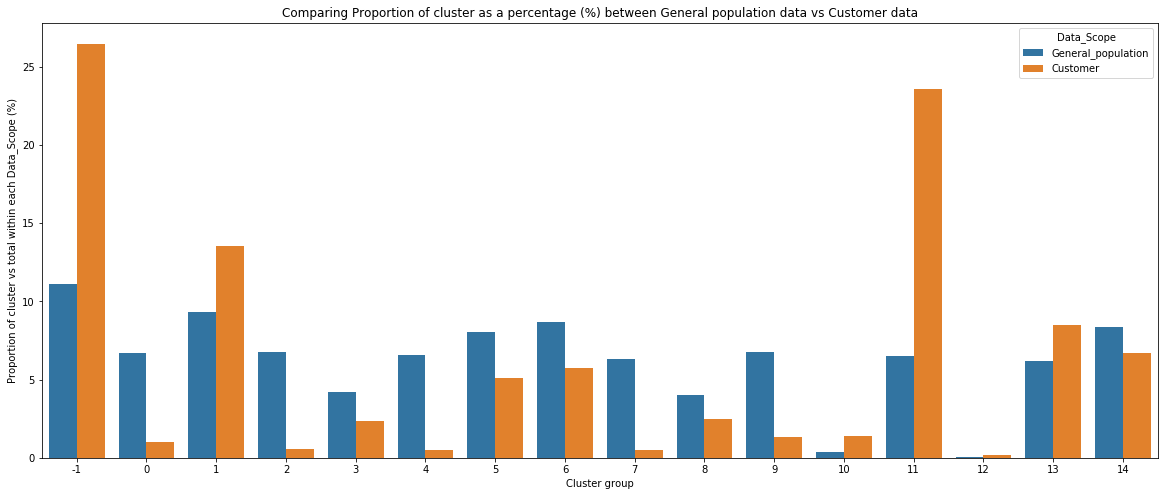

In [86]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Visual plot of the compiled data frame
compiled_predict_plot = sns.barplot(x='Predicted_Cluster_Label', 
                                    y='Cluster_Label_Prop', 
                                    hue='Data_Scope', 
                                    data=df_compiled_predict_label);
compiled_predict_plot.set_title('Comparing Proportion of cluster as a percentage (%) between General population data vs Customer data');
compiled_predict_plot.set_ylabel('Proportion of cluster vs total within each Data_Scope (%)');
compiled_predict_plot.set_xlabel('Cluster group');

#### Quick observations
The following observations are made from the table and plot above.

##### Callouts
- Cluster [-1] represents all the records that were excluded as they were missing > 15 feature values. We will exclude this cluster from the over and under representation analysis. 

##### Over-representation
These are clusters which have:
- Higher proportion in the customer data than in the population data

These clusters should be the target audience:
- Cluster 11 --> Has the largest over-representation


##### Under-representation
These are clusters which have:
- Lower proportion in the customer data than in the population data

These clusters should be the least targeted audience:
- Cluster 2 --> Has the largest under-representation


In [95]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


# We will look at the largest over-represented cluster: Cluster 11
cluster_over = kmeans_model_n_15.cluster_centers_[11]

# Convert to series of principal components
cluster_over_pc_series = pd.Series(data = cluster_over).sort_values(ascending=False)
cluster_over_pc_series.index = cluster_over_pc_series.index+1

# Convert to series of initial features
cluster_over_inverse = scaler.inverse_transform(pca_31.inverse_transform(cluster_over))
cluster_over_feat_series = pd.Series(data = cluster_over_inverse, 
                                    index = customers_processed_final.columns)

In [96]:
# Show the value of initial features for the cluster
cluster_over_feat_series

ALTERSKATEGORIE_GROB        3.294944
ANREDE_KZ                   1.055954
FINANZ_MINIMALIST           4.831920
FINANZ_SPARER               1.653276
FINANZ_VORSORGER            4.155952
FINANZ_ANLEGER              1.535490
FINANZ_UNAUFFAELLIGER       2.182975
FINANZ_HAUSBAUER            1.871630
GREEN_AVANTGARDE            0.988436
HEALTH_TYP                  2.083155
RETOURTYP_BK_S              3.964381
SEMIO_SOZ                   4.860901
SEMIO_FAM                   4.814312
SEMIO_REL                   3.722329
SEMIO_MAT                   3.922803
SEMIO_VERT                  6.236320
SEMIO_LUST                  5.204222
SEMIO_ERL                   4.107372
SEMIO_KULT                  4.893293
SEMIO_RAT                   2.701816
SEMIO_KRIT                  3.098511
SEMIO_DOM                   3.336664
SEMIO_KAEM                  2.649795
SEMIO_PFLICHT               3.192461
SEMIO_TRADV                 3.141711
SOHO_KZ                     0.008824
ANZ_PERSONEN                2.225249
A

In [97]:
# Show the weight of principal components for the cluster
cluster_over_pc_series

# From this we will pick the following:
# - Top 2 principal components: 3, 4

3     2.645195
4     2.330689
26    0.260051
5     0.255717
16    0.236097
21    0.165902
18    0.119913
19    0.066842
23    0.050971
28    0.050156
9     0.044743
7     0.034100
8     0.019513
10    0.004822
31    0.002303
17   -0.007098
27   -0.016227
29   -0.021713
6    -0.024730
12   -0.046453
30   -0.060430
25   -0.099131
14   -0.103447
24   -0.105496
22   -0.184080
13   -0.205581
2    -0.243551
11   -0.249555
20   -0.341012
15   -0.492264
1    -3.357355
dtype: float64

In [90]:
# - Top 2 principal components: 3, 4

view_pca_weights(pca_31, principal_component = 3, count_of_weights_presented_topbottom = 3)
print('-' * 150)
view_pca_weights(pca_31, principal_component = 4, count_of_weights_presented_topbottom = 3)

Principal Component number  3
------------------------------
Top 3 positive weights -->
------------------------------
SEMIO_VERT    0.3451
SEMIO_SOZ     0.2623
SEMIO_FAM     0.2490
Name: PC 3, dtype: float64
------------------------------
Top 3 negative weights -->
------------------------------
ANREDE_KZ    -0.3675
SEMIO_KAEM   -0.3353
SEMIO_DOM    -0.3130
Name: PC 3, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Principal Component number  4
------------------------------
Top 3 positive weights -->
------------------------------
GREEN_AVANTGARDE    0.4001
EWDICHTE            0.2607
ORTSGR_KLS9         0.2480
Name: PC 4, dtype: float64
------------------------------
Top 3 negative weights -->
------------------------------
MOVEMENT             -0.4001
KKK                  -0.2751
HH_EINKOMMEN_SCORE   -0.2421
Name: PC 4, dtype: float64


In [98]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


# We will look at the largest under-represented cluster: Cluster 2
cluster_under = kmeans_model_n_15.cluster_centers_[2]

# Convert to series of principal components
cluster_under_pc_series = pd.Series(data = cluster_under).sort_values(ascending=False)
cluster_under_pc_series.index = cluster_under_pc_series.index+1

# Convert to series of initial features
cluster_under_inverse = scaler.inverse_transform(pca_31.inverse_transform(cluster_under))
cluster_under_feat_series = pd.Series(data = cluster_under_inverse, 
                                    index = customers_processed_final.columns)

In [99]:
# Show the value of initial features for the cluster
cluster_under_feat_series

ALTERSKATEGORIE_GROB        1.798161
ANREDE_KZ                   0.953606
FINANZ_MINIMALIST           1.873556
FINANZ_SPARER               4.386427
FINANZ_VORSORGER            2.103242
FINANZ_ANLEGER              3.582319
FINANZ_UNAUFFAELLIGER       3.812157
FINANZ_HAUSBAUER            3.636274
GREEN_AVANTGARDE            0.127486
HEALTH_TYP                  2.349726
RETOURTYP_BK_S              2.749630
SEMIO_SOZ                   6.765848
SEMIO_FAM                   6.786745
SEMIO_REL                   6.363112
SEMIO_MAT                   5.089410
SEMIO_VERT                  6.073568
SEMIO_LUST                  2.888619
SEMIO_ERL                   2.118049
SEMIO_KULT                  6.913181
SEMIO_RAT                   4.118638
SEMIO_KRIT                  2.779622
SEMIO_DOM                   2.805631
SEMIO_KAEM                  2.399172
SEMIO_PFLICHT               5.682560
SEMIO_TRADV                 4.884934
SOHO_KZ                     0.008197
ANZ_PERSONEN                1.446040
A

In [100]:
# Show the weight of principal components for the cluster
cluster_under_pc_series

# From this we will pick the following:
# - Top 2 principal components: 1, 3

1     4.259813
3     2.504847
9     0.338444
22    0.186943
18    0.133782
16    0.098515
14    0.080375
20    0.053793
19    0.052474
7     0.046953
29    0.046033
5     0.038054
27    0.035404
30    0.022729
17    0.004116
25    0.002167
24   -0.004663
28   -0.006901
31   -0.017848
23   -0.027135
4    -0.033759
15   -0.042920
12   -0.067480
21   -0.082298
13   -0.137880
26   -0.158926
6    -0.219748
11   -0.238586
8    -0.287482
10   -0.288488
2    -2.671442
dtype: float64

In [101]:
# - Top 2 principal components: 1, 3

view_pca_weights(pca_31, principal_component = 1, count_of_weights_presented_topbottom = 3)
print('-' * 150)
view_pca_weights(pca_31, principal_component = 3, count_of_weights_presented_topbottom = 3)

Principal Component number  1
------------------------------
Top 3 positive weights -->
------------------------------
PLZ8_ANTG3    0.2251
PLZ8_ANTG4    0.2170
WEALTH        0.2049
Name: PC 1, dtype: float64
------------------------------
Top 3 negative weights -->
------------------------------
MOBI_REGIO          -0.2261
PLZ8_ANTG1          -0.2254
FINANZ_MINIMALIST   -0.2230
Name: PC 1, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Principal Component number  3
------------------------------
Top 3 positive weights -->
------------------------------
SEMIO_VERT    0.3451
SEMIO_SOZ     0.2623
SEMIO_FAM     0.2490
Name: PC 3, dtype: float64
------------------------------
Top 3 negative weights -->
------------------------------
ANREDE_KZ    -0.3675
SEMIO_KAEM   -0.3353
SEMIO_DOM    -0.3130
Name: PC 3, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data


##### Over-represented segments (Popular with the company)
Cluster/segment 1 is the most over-represented segment. 
It has the following main principal components: 3 (weight of 2.645195), 4 (weight of 2.330689)
- For principal component: 3
 - Top 3 positive weights:
 >- SEMIO_VERT    [Feature value: ~6.2] --> [Weight in prin_comp: 0.3451] (Less dreamful personality)
 >- SEMIO_SOZ     [Feature value: ~4.8] --> [Weight in prin_comp: 0.2623] (Average to low socially-minded personality)
 >- SEMIO_FAM     [Feature value: ~4.8] --> [Weight in prin_comp: 0.2490] (Average to low family-minded personality) 
 - Top 3 negative weights:
 >- ANREDE_KZ   [Feature value: ~1.0] --> [Weight in prin_comp: -0.3675] (Unlikely Gender is male)
 >- SEMIO_KAEM  [Feature value: ~2.6] --> [Weight in prin_comp: -0.3353] (Unlikely Highly combative attitude)
 >- SEMIO_DOM   [Feature value: ~3.3] --> [Weight in prin_comp: -0.3130] (Unlikely Highly dominant-minded)
 
- For principal component: 4
 - Top 3 positive weights:
 >- GREEN_AVANTGARDE  [Feature value: ~0.98] --> [Weight in prin_comp: 0.4001] (Likely has Membership in environmental sustainability as part of youth)
 >- EWDICHTE          [Feature value: ~3.9] --> [Weight in prin_comp: 0.2607] (Lives in place with density of 150-319 households per square kilometer)
 >- ORTSGR_KLS9       [Feature value: ~5.3] --> [Weight in prin_comp: 0.2480] (Lives in community of 20,001 to 50,000 people)
 - Top 3 negative weights:
 >- MOVEMENT           [Feature value: ~0.0] --> [Weight in prin_comp: -0.4001] (Unlikely Follows Avantgarde movement in youth)
 >- KKK                [Feature value: ~2.1] --> [Weight in prin_comp: -0.2751] (Unlikely High Purchasing power in region)
 >- HH_EINKOMMEN_SCORE [Feature value: ~2.4] --> [Weight in prin_comp: -0.2421] (Unlikely High Estimated household net income)

This segment can be described as people who place a relatively low focus on socialising, family and dreams. They do not have aggresive personalities and are conservative when it comes to experimenting new things. They live in rather densely populated places and large communities, potentially due to socio-economic pressures. Supporting this, they have relatively low household income, leading to low purchasing power. However, they care deeply for the environment.


##### Under-represented segments (Unpopular with the company)
Cluster/segment 13 is the most under-represented segment. 
It has the following main principal components: 1 (weight of 4.259813), 3 (weight of 2.504847). Given that principal component 1 carries substantially more weight than the other components, we will focus on component 1 only:
- For principal component: 1
 - Top 3 positive weights:
 >- PLZ8_ANTG3   [Feature value: ~2.4] --> [Weight in prin_comp: 0.2251] (Average share of 6-10 family homes)
 >- PLZ8_ANTG4   [Feature value: ~1.2] --> [Weight in prin_comp: 0.2170] (Low share of 10+ family homes)
 >- WEALTH       [Feature value: ~4.3] --> [Weight in prin_comp: 0.2049] (Less affluent households)
 - Top 3 negative weights:
 >- MOBI_REGIO        [Feature value: ~1.7] --> [Weight in prin_comp: -0.2261] (Unlikely to have High movement across regions)
 >- PLZ8_ANTG1        [Feature value: ~1.4] --> [Weight in prin_comp: -0.2254] (Unlikely to have Low to average share 1-2 family houses in region)
 >- FINANZ_MINIMALIST [Feature value: ~1.8] --> [Weight in prin_comp: -0.2230] (Unlikely to have low financial interest) 

This segment can be described as people with are financially aware given that they are from less affluent backgrounds. They tend to have average to low family properties, but more than 1-2 as it is likely they have larger families. They move infrequently between regions.  

> ***Please note: The clusters for under and over representation will change when model is re-rerun. The analysis above is relevant for the clusters that were generated at the time of writing.***  